In [1]:
%matplotlib inline 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# from pandas_profiling import ProfileReport
import numpy as np

In [2]:
df = pd.read_csv('data/data_Inmeta.csv', sep=';', header=0)
df.head(20)

,Y,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,13500,23,46986,1.0,90,1,0,2000,3,1165
1,13750,23,72937,1.0,90,1,0,2000,3,1165
2,13950,24,41711,1.0,90,1,0,2000,3,1165
3,14950,26,48000,1.0,90,0,0,2000,3,1165
4,13750,30,38500,1.0,90,0,0,2000,3,1170
5,12950,32,61000,1.0,90,0,0,2000,3,1170
6,16900,27,94612,1.0,90,1,0,2000,3,1245
7,18600,30,75889,1.0,90,1,0,2000,3,1245
8,21500,27,19700,0.0,192,0,0,1800,3,1185
9,12950,23,71138,1.0,69,0,0,1900,3,1105


# Exploratory Data Analysis

## General

In [3]:
print(df.describe())
print(df.info())

                  Y    Feature 1      Feature 2   Feature 3    Feature 4  \
count   1436.000000  1436.000000    1436.000000  414.000000  1436.000000   
mean   10730.824513    55.947075   68533.259749    0.173913   101.502089   
std     3626.964585    18.599988   37506.448872    0.379493    14.981080   
min     4350.000000     1.000000       1.000000    0.000000    69.000000   
25%     8450.000000    44.000000   43000.000000    0.000000    90.000000   
50%     9900.000000    61.000000   63389.500000    0.000000   110.000000   
75%    11950.000000    70.000000   87020.750000    0.000000   110.000000   
max    32500.000000    80.000000  243000.000000    1.000000   192.000000   

         Feature 5    Feature 6    Feature 7    Feature 8   Feature 9  
count  1436.000000  1436.000000  1436.000000  1436.000000  1436.00000  
mean      0.674791     0.055710  1566.827994     4.033426  1072.45961  
std       0.468616     0.229441   187.182436     0.952677    52.64112  
min       0.000000     0.00

Binary features: 3, 5, 6, Mising values features: 3
Scales are different between features.

<AxesSubplot:>

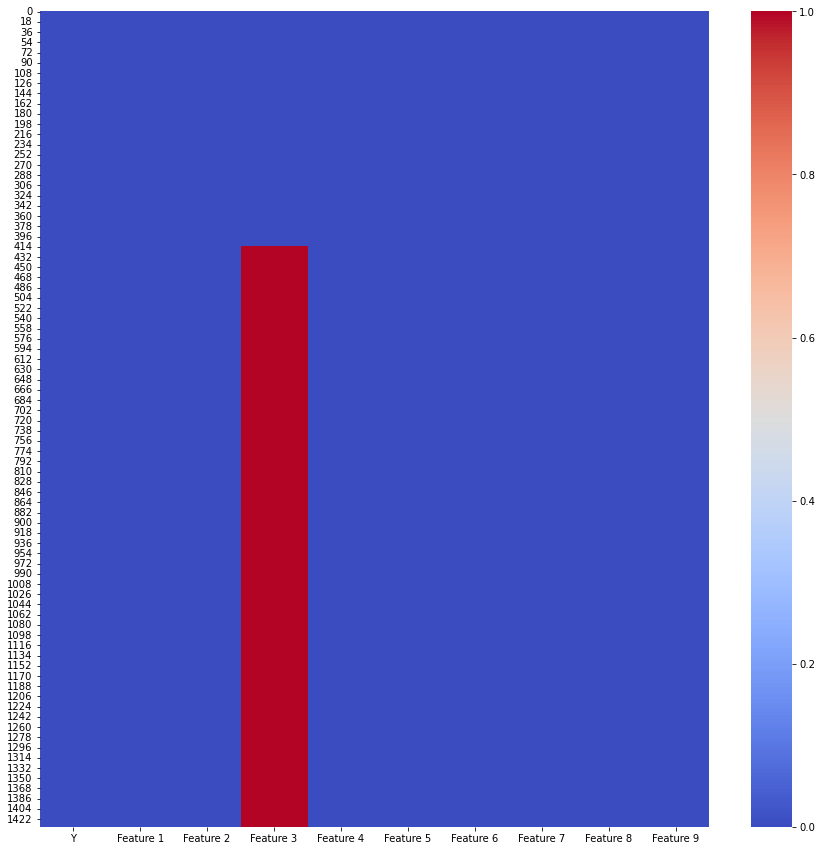

In [4]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.isnull(), cmap='coolwarm', cbar=True)

<AxesSubplot:>

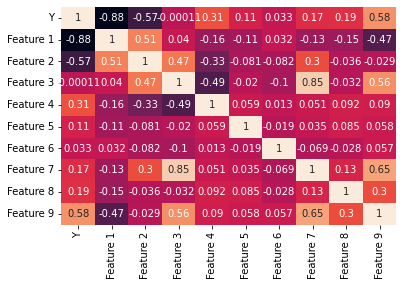

In [5]:
sns.heatmap(df.corr(), annot=True, cbar=False)

## Missing values, duplicated values

In [6]:
# Find the duplications
df[df.duplicated(keep=False)]

,Y,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
112,24950,8,13253,1.0,116,1,0,2000,5,1320
113,24950,8,13253,1.0,116,1,0,2000,5,1320


23915.000000000007
Number of points above extreme:  8
Number of points below extreme:  8


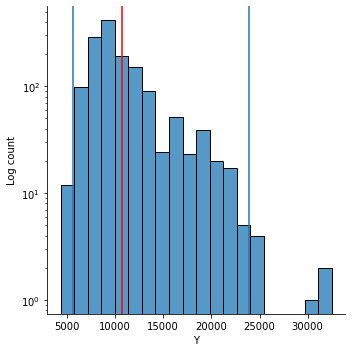

In [7]:
sns.displot(df['Y'], bins=20)
plt.yscale('log')
plt.axvline(df['Y'].mean(), c='red', label='mean')
plt.axvline(np.percentile(df['Y'], q=99.5), label='99.5 percentile')
plt.axvline(np.percentile(df['Y'], q=0.5), label='0.5 percentile')
threshold = np.percentile(df['Y'], q=99.5)
plt.ylabel('Log count')
print(threshold)
print('Number of points above extreme: ', len(df[df['Y'] > np.percentile(df['Y'], q=99.5)]))
print('Number of points below extreme: ', len(df[df['Y'] < np.percentile(df['Y'], q=0.5)]))

In [8]:
# # Pandas profiling
# profile = ProfileReport(df)
# profile

# Data Preprocessing

## Drop missing column and duplicated row

In [9]:
# Drop column feature 3
df_clean = df.drop('Feature 3', axis=1)
# Drop duplicates
df_clean = df_clean.drop_duplicates(keep='first')

In [10]:
# Filter outliers using 0.5, 99.5 percentile
print('threshold ', threshold)
df_clean = df_clean[df_clean['Y'] > np.percentile(df_clean['Y'], q=0.5)]
df_clean = df_clean[df_clean['Y'] <= np.percentile(df_clean['Y'], q=99.5)]
print('Shape after filter ', df_clean.shape)

threshold  23915.000000000007
Shape after filter  (1419, 9)


## Seperate X, y

In [11]:
X = df_clean.drop('Y', axis=1)
# X = np.array(df_clean['Feature 1']).reshape(-1, 1)
y = df_clean['Y']

## Scaler

In [12]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
X = scl.fit_transform(X)


In [13]:
pd.DataFrame(X).describe()

,0,1,2,3,4,5,6,7
count,1419.000000,1419.000000,1419.000000,1419.000000,1419.000000,1419.000000,1419.000000,1419.000000
mean,0.698879,0.281617,0.264167,0.673714,0.056378,0.376890,0.675123,0.115142
std,0.231454,0.151544,0.119675,0.469019,0.230731,0.264123,0.317574,0.078096
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.544304,0.177198,0.170732,0.000000,0.000000,0.142857,0.333333,0.065041
50%,0.759494,0.261112,0.333333,1.000000,0.000000,0.428571,0.666667,0.105691
75%,0.873418,0.357792,0.333333,1.000000,0.000000,0.428571,1.000000,0.138211
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## PCA (disabled)

In [14]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=4)
# X = pca.fit_transform(X)
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')

## Train test split

In [15]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Utils

In [16]:
#Visualization code

def vis(y_test, y_pred):

    # Distribution on the line
    fig, ax = plt.subplots(3, 1, figsize=(20,20))
    ax[0].scatter(y_pred, y_test, color='red')
    ax[0].set_xlabel('Predictions', fontsize = 15)
    ax[0].set_ylabel('Ground truths', fontsize = 15)
    ax[0].set_title('Predictions x Ground truths on dataset', fontsize = 15)
    ax[0].plot([0, max(y_test)], [0, max(y_test)], 'g--')

    # Scatter overlapping
    x = range(len(y_test))
    ax[1].scatter(x, y_test, color='blue', label='Ground truth', marker='o')
    ax[1].scatter(x, y_pred, color='green', label='Predictions', marker='x')
    ax[1].legend(loc='upper right')
    ax[1].set_title('Scatter plot of ground truth and prediction', fontsize = 15)

    # Residual histogram
    sns.histplot(abs(y_pred - y_test), ax=ax[2], bins=10)
    ax[2].set_title('Residuals distribution', fontsize = 15)
    
    print('RMSE', mean_squared_error(y_test, y_pred, squared=False))
    print('MSE:', mean_squared_error(y_test, y_pred))
    print('MAE: ', mean_absolute_error(y_test, y_pred))
    print('r2_score: ', r2_score(y_test, y_pred))


    plt.show()
    

In [17]:
def read_cv_test_result(cv_dict, cv=5):
    dic = dict()
    for key in cv_dict.keys():
        if key.startswith('test'):
            dic['Average {}-fold '.format(cv)+key] = cv_dict[key].mean()
            # print('Average {}-fold '.format(cv)+key)
            # print(cv_dict[key].mean())
    
    print(pd.DataFrame(cv_dict).head(20))
    return(dic)


# Data modelling

In [18]:
cv_scoring_metrics = ('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_root_mean_squared_error')
folds = KFold(n_splits=5, shuffle=True, random_state=123)

## Linear Regression

RMSE 1353.4618386617517
MSE: 1831858.9487136498
MAE:  936.0191033059484
r2_score:  0.8434437487468157


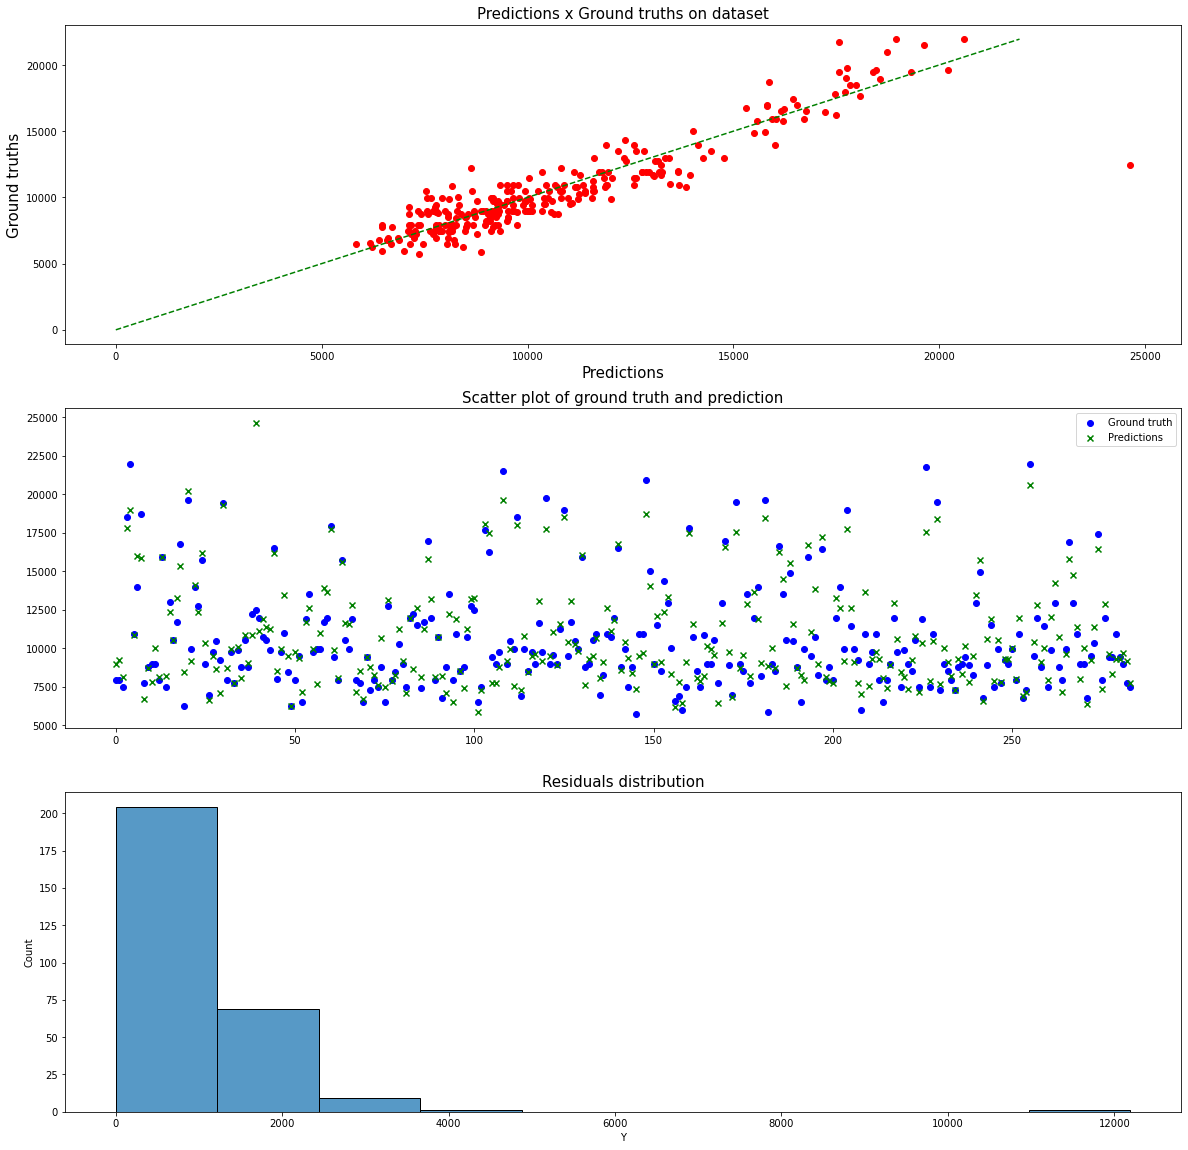

In [19]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
vis(y_test, y_predict)

In [20]:
# Cross validation
lr_cv_scores = cross_validate(lr, X, y, cv=folds, scoring=cv_scoring_metrics)
lr_dict = read_cv_test_result(lr_cv_scores)

   fit_time  score_time   test_r2  test_neg_mean_squared_error  \
0  0.001429    0.000683  0.843444                -1.831859e+06   
1  0.001083    0.000624  0.865330                -1.557050e+06   
2  0.000635    0.000530  0.880067                -1.418117e+06   
3  0.000546    0.000507  0.840840                -1.648038e+06   
4  0.000605    0.000593  0.843006                -1.780635e+06   

   test_neg_mean_absolute_error  test_neg_root_mean_squared_error  
0                   -936.019103                      -1353.461839  
1                   -950.354087                      -1247.817992  
2                   -922.202899                      -1190.847249  
3                   -950.230699                      -1283.759184  
4                   -977.091141                      -1334.404217  


## Decision Tree

RMSE 1287.1931563797975
MSE: 1656866.221830986
MAE:  1000.75
r2_score:  0.858399160754143


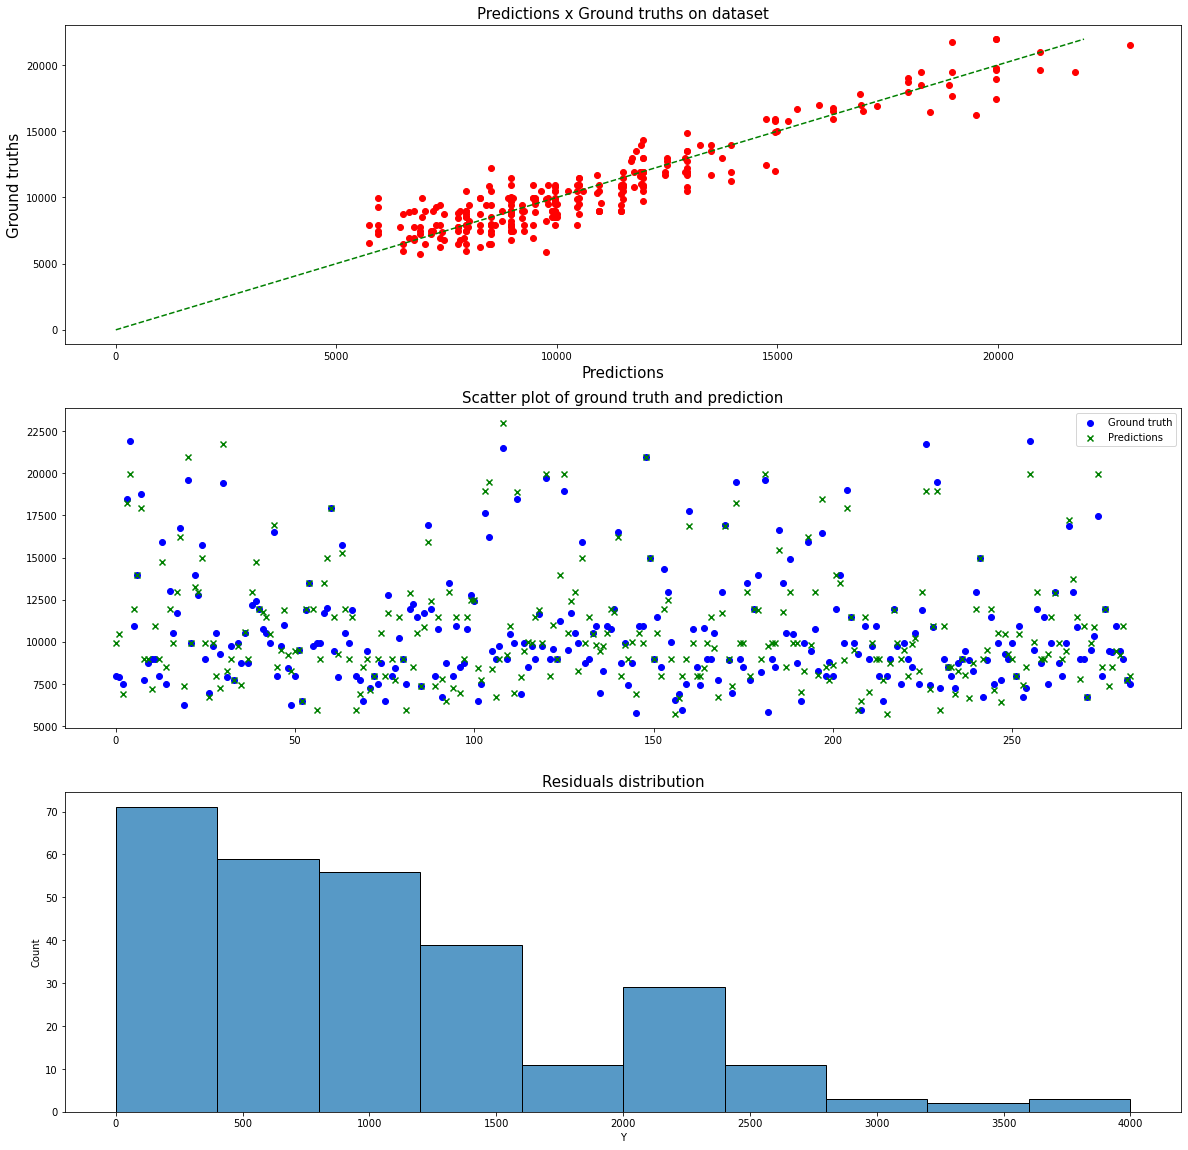

In [21]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
dc = DecisionTreeRegressor()
dc.fit(X_train, y_train)
dc_pred = dc.predict(X_test)
vis(y_test, dc_pred)

In [22]:
dc_cv_scores = cross_validate(dc, X, y, cv=folds, scoring=cv_scoring_metrics)
dc_dict = read_cv_test_result(dc_cv_scores)

   fit_time  score_time   test_r2  test_neg_mean_squared_error  \
0  0.003667    0.000747  0.849027                -1.766526e+06   
1  0.003065    0.000546  0.810917                -2.186168e+06   
2  0.002922    0.000589  0.839711                -1.895293e+06   
3  0.003138    0.000755  0.770690                -2.374403e+06   
4  0.003000    0.000539  0.837174                -1.846778e+06   

   test_neg_mean_absolute_error  test_neg_root_mean_squared_error  
0                  -1029.232394                      -1329.107118  
1                  -1086.179577                      -1478.569656  
2                  -1087.232394                      -1376.696490  
3                  -1166.521127                      -1540.909796  
4                  -1053.031802                      -1358.962140  


## Random Forest

RMSE 1001.8859051026269
MSE: 1003775.3668433098
MAE:  803.3143309859155
r2_score:  0.9142142965518012


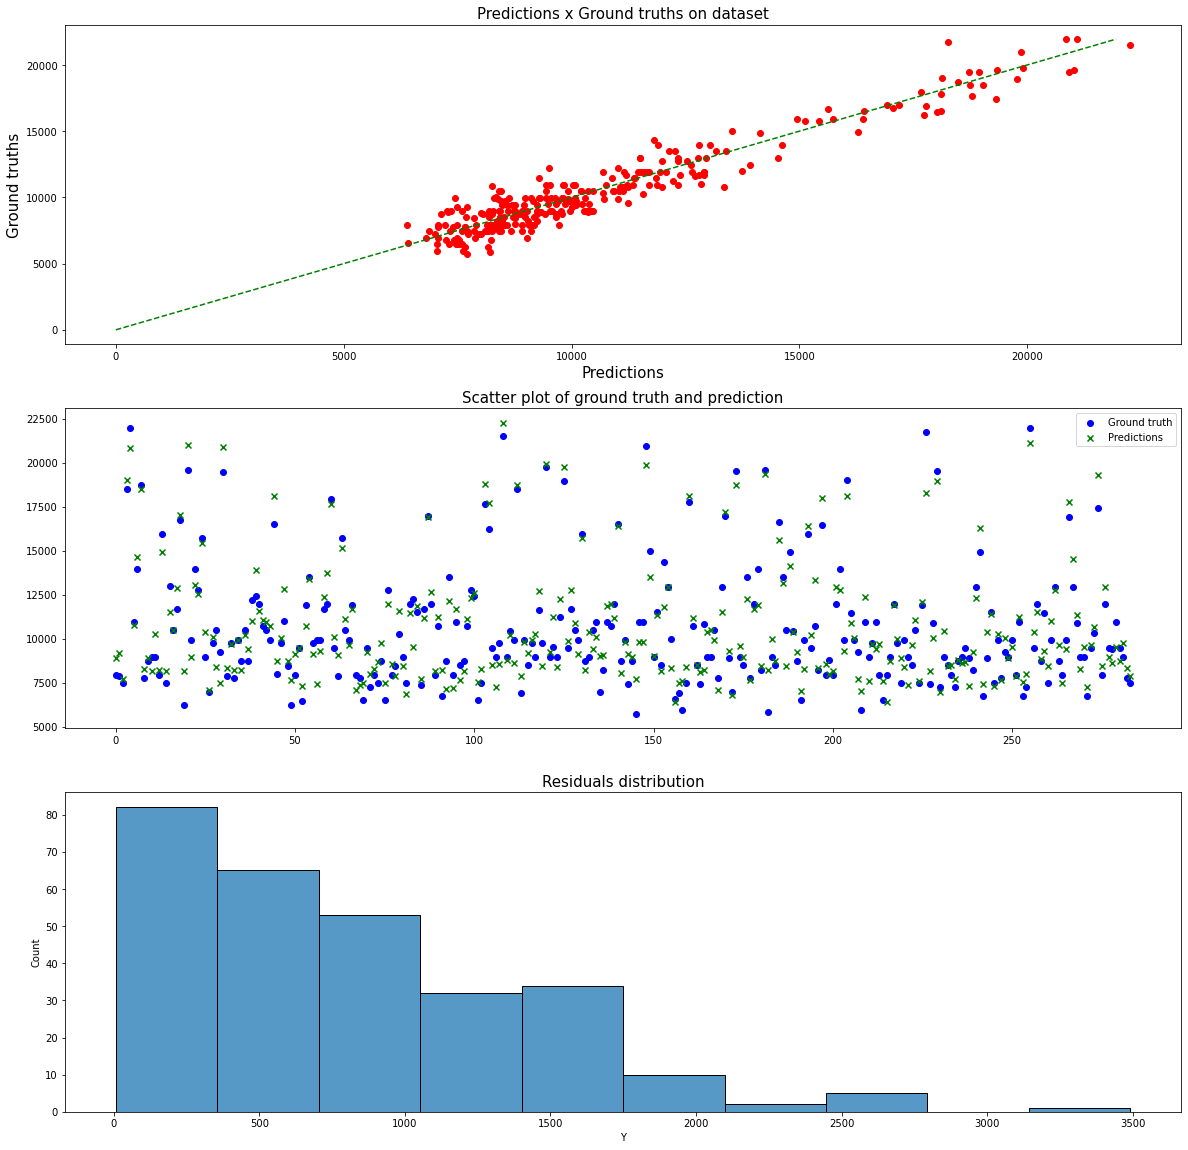

In [23]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)
vis(y_test, rf_predict)

In [24]:
rf_cv_scores = cross_validate(rf, X, y, cv=folds, scoring=cv_scoring_metrics)
rf_dict = read_cv_test_result(rf_cv_scores)

   fit_time  score_time   test_r2  test_neg_mean_squared_error  \
0  0.218974    0.007041  0.911839                -1.031574e+06   
1  0.211266    0.006943  0.897207                -1.188483e+06   
2  0.212410    0.007060  0.904377                -1.130674e+06   
3  0.212614    0.006970  0.882772                -1.213850e+06   
4  0.211143    0.006947  0.901649                -1.115501e+06   

   test_neg_mean_absolute_error  test_neg_root_mean_squared_error  
0                   -810.404190                      -1015.664096  
1                   -827.895751                      -1090.175729  
2                   -844.604004                      -1063.331728  
3                   -811.138768                      -1101.748605  
4                   -800.064099                      -1056.172993  


In [25]:
# feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
# feat_importances.nlargest(20).plot(kind='bar')

## XGBoost

RMSE 1092.2476161860998
MSE: 1193004.8550642175
MAE:  863.9138080435739
r2_score:  0.8980421675113929


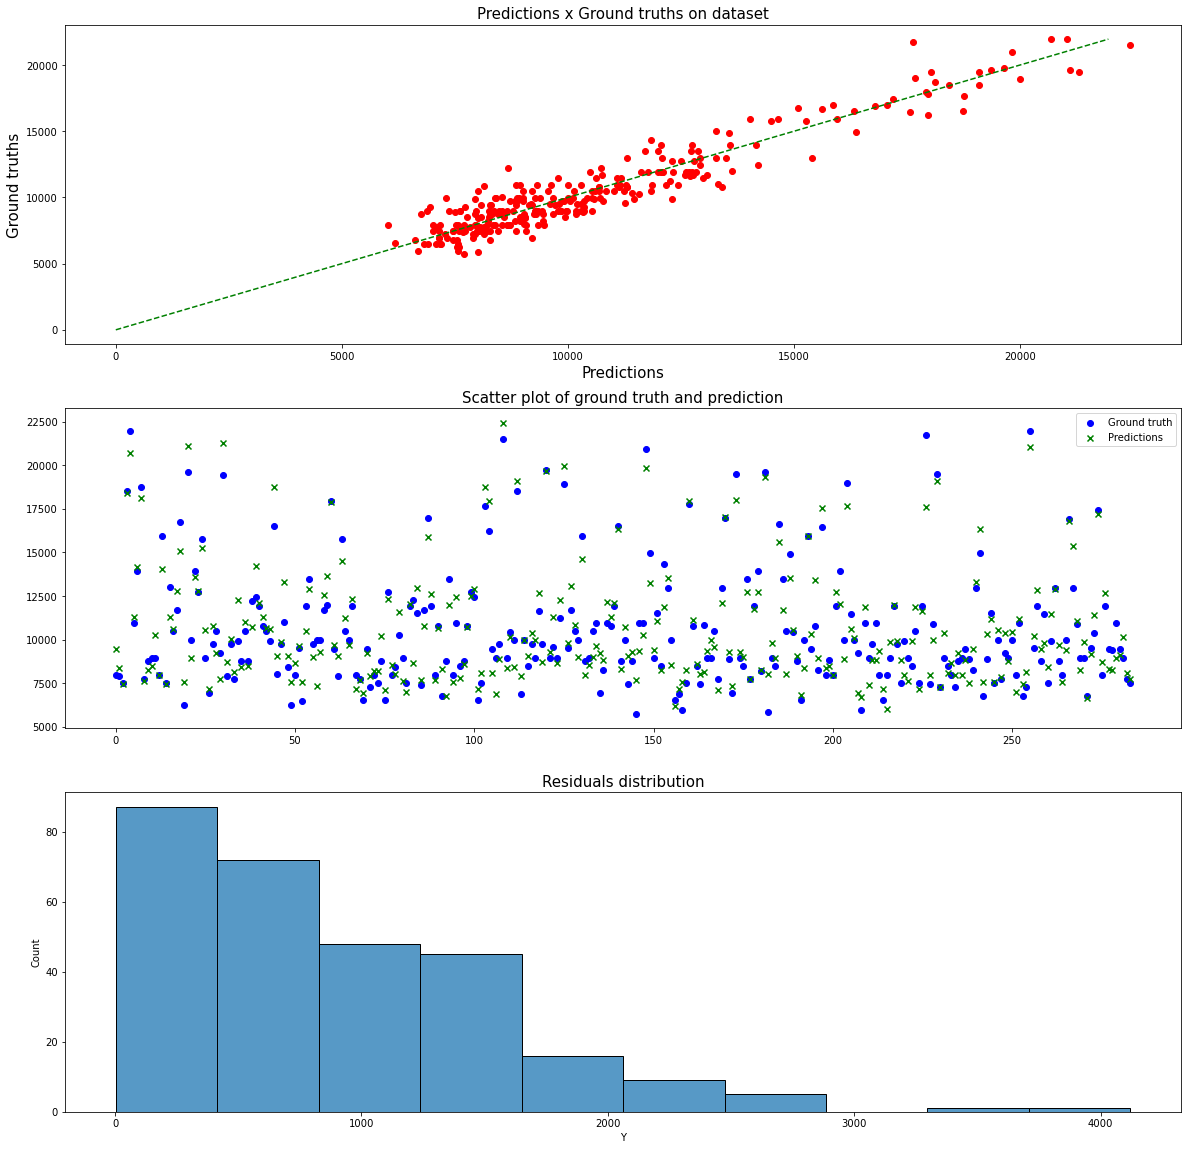

In [26]:
from xgboost import XGBRegressor
xg = XGBRegressor()
xg.fit(X_train, y_train)
xg_pred = xg.predict(X_test)
vis(y_test, xg_pred)

In [27]:
# feat_importances = pd.Series(xg.feature_importances_, index=X.columns)
# feat_importances.nlargest(20).plot(kind='bar')

In [28]:
xg_cv_scores = cross_validate(xg, X, y, cv=folds, scoring=cv_scoring_metrics)
xg_dict = read_cv_test_result(xg_cv_scores)

   fit_time  score_time   test_r2  test_neg_mean_squared_error  \
0  0.183048    0.002235  0.898042                -1.193005e+06   
1  0.095932    0.003400  0.885941                -1.318748e+06   
2  0.114126    0.002080  0.901259                -1.167535e+06   
3  0.103735    0.001921  0.875419                -1.289977e+06   
4  0.096787    0.002041  0.894807                -1.193105e+06   

   test_neg_mean_absolute_error  test_neg_root_mean_squared_error  
0                   -863.913808                      -1092.247616  
1                   -869.548883                      -1148.367396  
2                   -847.855632                      -1080.525285  
3                   -863.205025                      -1135.771631  
4                   -832.133922                      -1092.293279  


## ANN

In [29]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential

In [30]:
from tensorflow.keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def build_model(input_shape, depth=3, hidden_nodes=[30, 20, 20, 30], ):
    ann = Sequential()
    ann.add(Input(shape=X_train.shape[1]))

    for i in range(depth):
        if(isinstance(hidden_nodes, list)):
            ann.add(Dense(hidden_nodes[i], activation='relu'))
        elif(isinstance(hidden_nodes, int)):
            ann.add(Dense(hidden_nodes, activation='relu'))

    ann.add(Dense(1, activation='linear'))
    ann.summary()

    ann.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error', 'mse', coeff_determination])
    return ann

In [3]:
ann = build_model(input_shape=X_train.shape[1])
ann.fit(X_train, y_train, epochs=300)
ann_pred = ann.predict(X_test)
vis(y_test, ann_pred.reshape(-1))

NameError: name 'build_model' is not defined

In [1]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
estimator = KerasRegressor(build_fn = lambda: build_model(X.shape[1]), epochs=300, verbose=False)
ann_cv_results = cross_validate(estimator, X, y, cv=folds, scoring=cv_scoring_metrics)

NameError: name 'cross_validate' is not defined

In [ ]:
ann_dict = read_cv_test_result(ann_cv_results)

# Conclusion

In [ ]:
conclusion_df = pd.DataFrame([lr_dict, dc_dict, rf_dict, xg_dict, ann_dict])
conclusion_df['Model name'] = ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'ANN']
conclusion_df.set_index('Model name', inplace=True)
conclusion_df.to_csv('Minmax_scaling.csv')
conclusion_df.head(10)

Tree Esemble methods perform best on this problem
--> Lesson learn: apply dropout to ANN